В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [28]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


d:\PyPrograms\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Визуальный анализ ряда

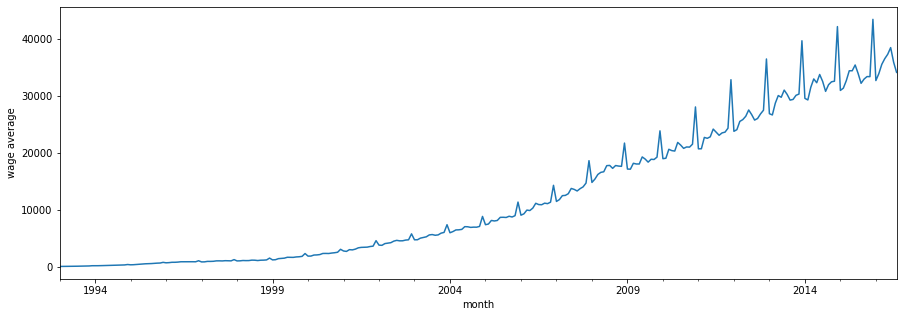

In [7]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,5))
data.WAG_C_M.plot()
plt.ylabel('wage average')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

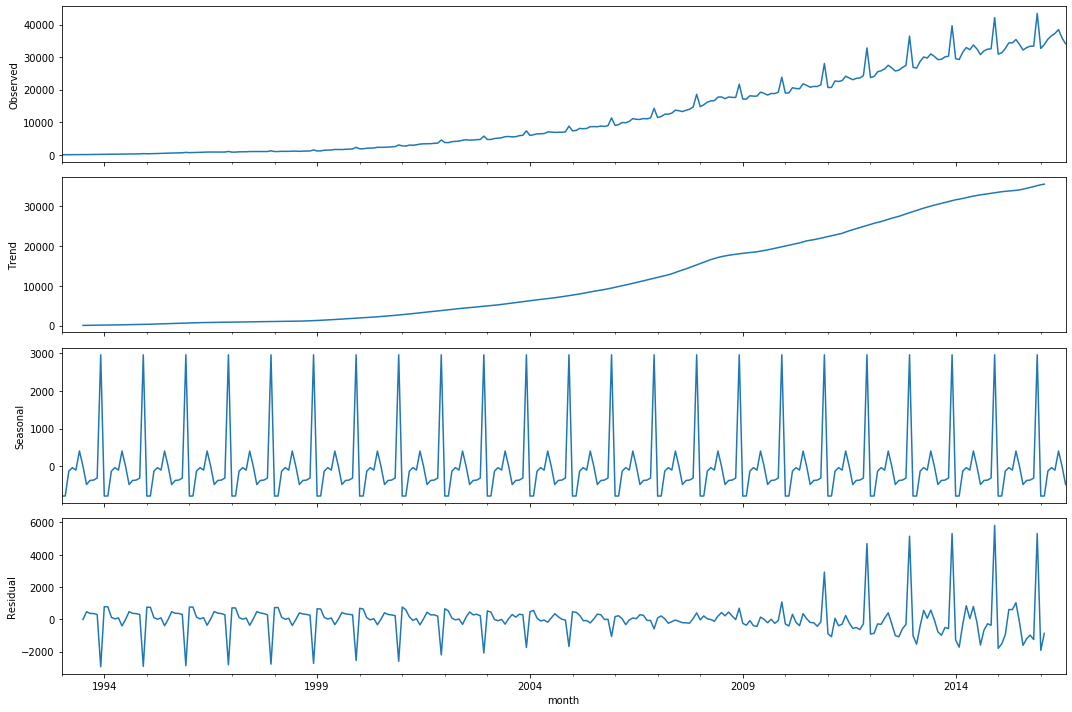

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

В ряде наблюдаются общий и сезонный тренд, а также рост дисперсии.<br>Также отвегается гипотеза, что случайный процесс стационарный<br>Очевидно, требуется стабилизация дисперсии

#### Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


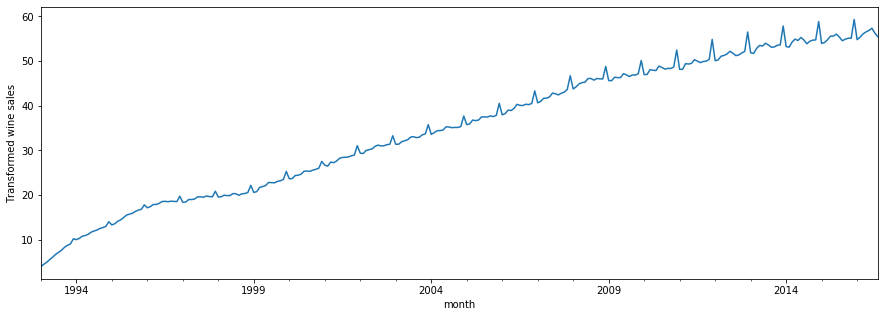

In [13]:
data['wage_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,5))
data.wage_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

#### Выбор порядка дифференцирования
В ряде остается общий и сезонный тренд, поэтому, проведем сезонное и обычное дифференцирование, начнем с сезонного

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

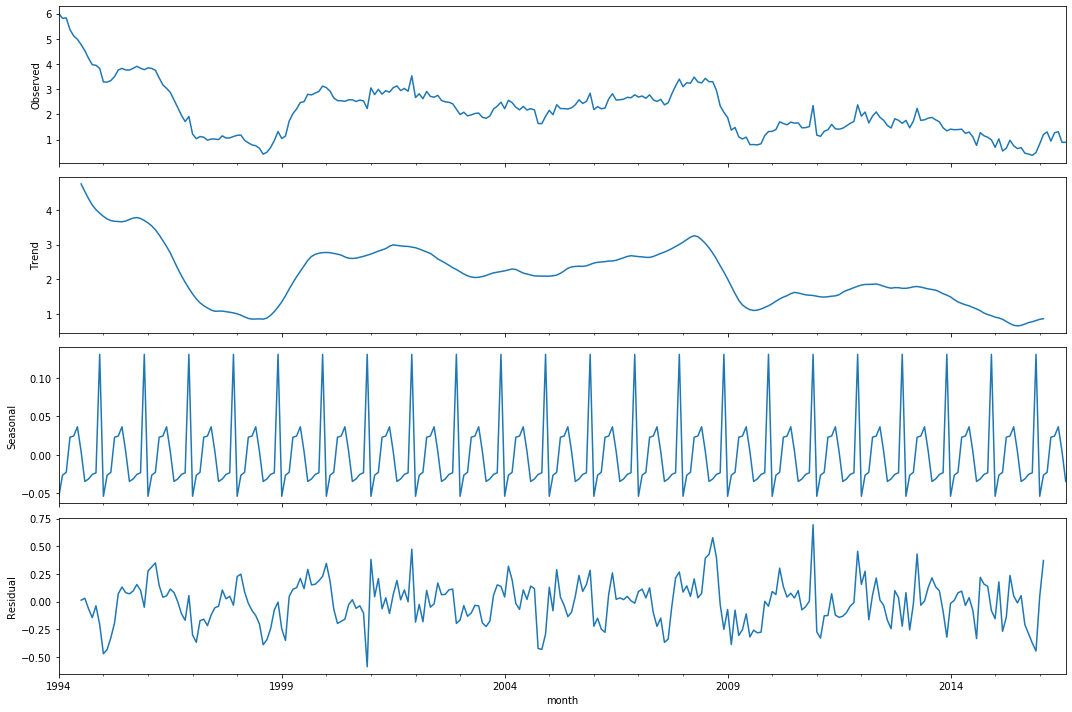

In [17]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

Виден тренд, добавим обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

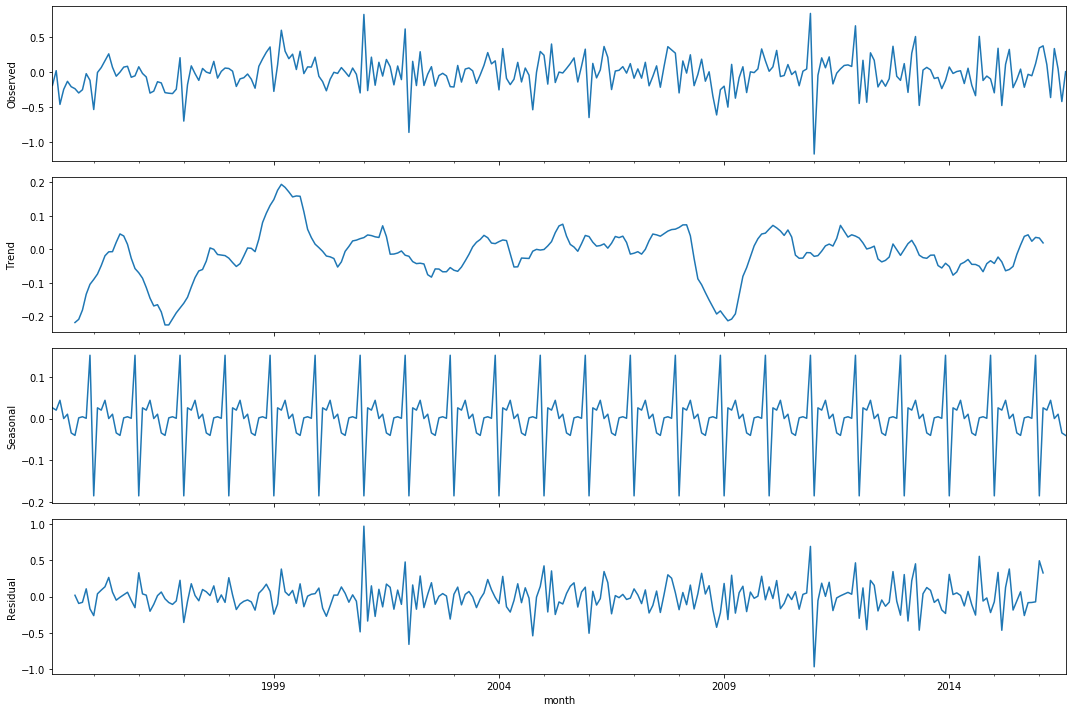

In [18]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

#### Выбор начальных приближений для p, q, P, Q
Для выбора начальных p, q, P, Q строится ACF и PACF полученного ряда:

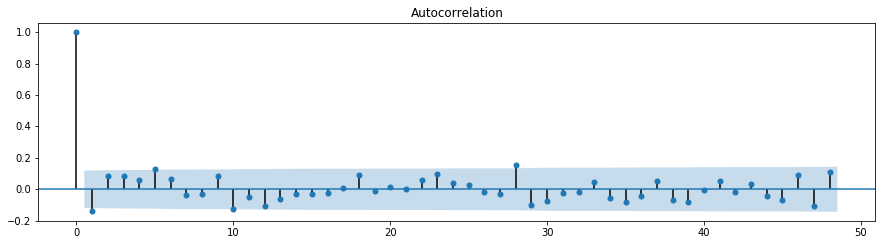

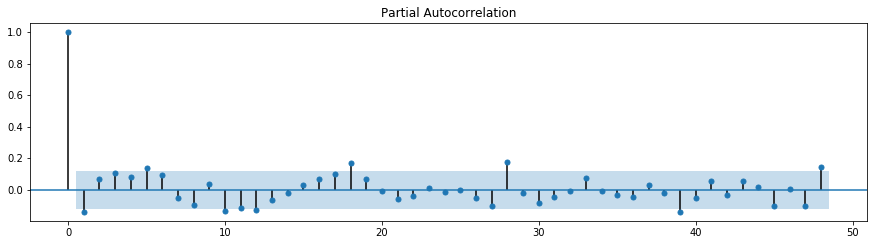

In [21]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=1

#### Обучение и сравнение моделей-кандидатов, выбор победителя

In [22]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 6s


Модели с параметрами:

In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
32  (2, 2, 0, 0) -21.488595
34  (2, 2, 1, 0) -21.473457
33  (2, 2, 0, 1) -21.240102
35  (2, 2, 1, 1) -21.053117
44  (3, 2, 0, 0) -20.263395


Лучшая модель:

In [25]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                  15.744
Date:                            Sun, 31 May 2020   AIC                            -21.489
Time:                                    00:04:36   BIC                             -3.478
Sample:                                01-01-1993   HQIC                           -14.257
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.946      0.000       1.400       1.571
ar.L2         -0.6838      0.043   

#### Анализ остатков построенной модели

Критерий Стьюдента: p=0.269847
Критерий Дики-Фуллера: p=0.000000


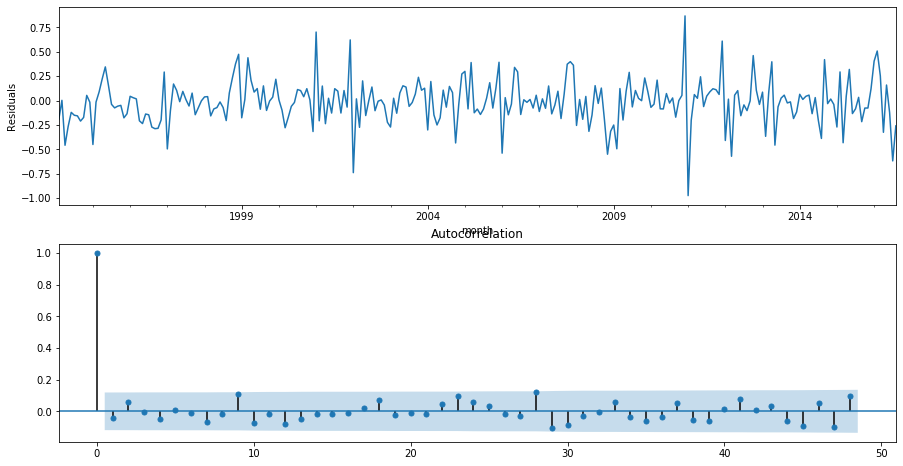

In [27]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки модели несмещены, так как критерий Стъюдента подтверждает гипотезу о равенстве нулю матожидания соотв. распределения. Критерий Дики-Фуллера отвергает гипотезу о нестационарности остатков. Отсутствие автокорреляции видно из коррелограммы. Также, можно оценить визуально качество модели:

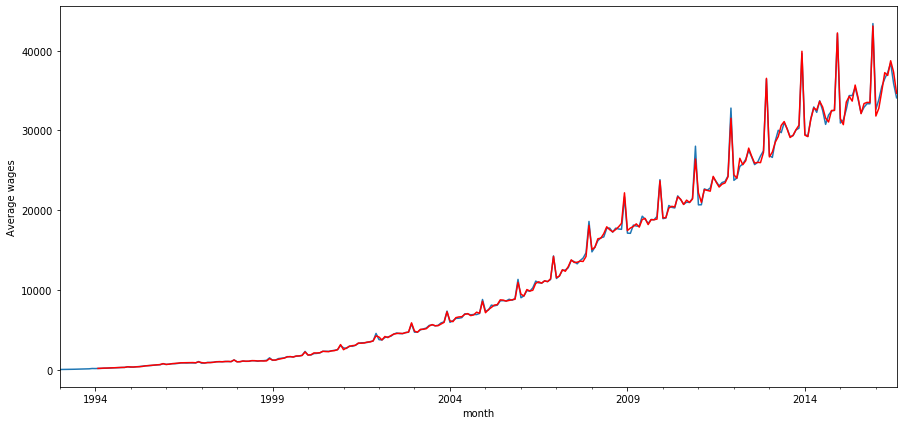

In [30]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Average wages')
pylab.show()

#### Прогнозирование с помощью финальной модели.

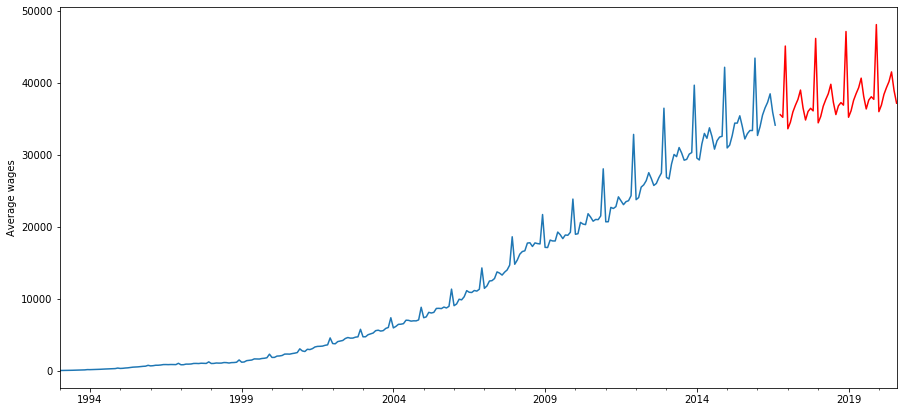

In [31]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=285, end=332), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Average wages')
pylab.show()